# Initialization

In [156]:
from src.SIV_library.lib import SIV, OpticalFlow
from src.SIV_library.advanced import Warp, CTF, Refine

import os
import sys
import torch
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# plt.rcParams["animation.html"] = "jshtml"
# %matplotlib notebook
%matplotlib inline

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)

if device == "cuda":
    torch.cuda.empty_cache()
    
folder = r"../Test Data/Full big vid PROCESSED"

device: cuda


# Matching

In [158]:
mode = 1

siv_gen = SIV(
    folder=folder, 
    device=device, 
    window_size=128, 
    overlap=64, 
    search_area=(50, 0, 0, 0), 
    mode=mode, 
    num_passes=2, 
    scale_factor=0.5
)

In [17]:
idx = 0
u1_avg = torch.zeros((len(siv_gen.dataset),))

for res in siv_gen():
    x, y, u, v = res
    
    warp = Warp(x, y, u, v)
    warp.interpolate_field(siv_gen.dataset.img_shape)
    u1_avg[idx] = torch.mean(warp.u)

    idx += 1

SAD: 100%|██████████| 2675/2675 [07:43<00:00,  5.77it/s]


Interpolate velocity field:

# Optical flow

In [159]:
opti_gen = OpticalFlow(
    folder=folder, 
    device=device, 
    alpha=100., 
    num_iter=1000, 
    eps=0.
)

In [25]:
idx = 0
u2_avg = torch.zeros((len(opti_gen.dataset),))

for res in opti_gen():
    x, y, u, v = res
    u2_avg[idx] = torch.mean(u)
    idx += 1

Optical flow: 100%|██████████| 2675/2675 [49:54<00:00,  1.12s/it]


Course-to-fine optical flow:

In [160]:
ctf_gen = CTF(opti_gen, num_passes=4, scale_factor=1/2)

In [128]:
idx = 0
u3_avg = torch.zeros((len(ctf_gen.dataset),))

for res in ctf_gen():
    x, y, u, v = res
    u3_avg[idx] = torch.mean(u)
    idx += 1

100%|██████████| 2675/2675 [2:11:50<00:00,  2.96s/it]  


# Hybrid method (matching + optical flow)

In [161]:
refine_gen = Refine(siv_gen, opti_gen)

In [107]:
idx = 0
u4_avg = torch.zeros((len(refine_gen.dataset),))

for res in refine_gen():
    x, y, u, v = res
    u4_avg[idx] = torch.mean(u)
    idx += 1

100%|██████████| 19/19 [00:22<00:00,  1.18s/it]


# Loading data

In [246]:
def get_datetimes(folder):
    time_objects = []
    
    for file in os.listdir(folder):
        name_formatted = (file[:-4].split("_"))
        name_formatted[-1] = f"{name_formatted[-1]}000"
        name_formatted = [name_formatted[2], name_formatted[1], name_formatted[0], *name_formatted[3:]]
        time = ':'.join(name_formatted[3:])
        time_objects.append(datetime.strptime(time, '%H:%M:%S:%f') - timedelta(seconds=3.736))
    return time_objects

ds = get_datetimes(folder)
start = ds[0]
ds = [(t - start).total_seconds() for t in ds]

In [247]:
testo = pd.read_csv("../Test Data/testo.csv", sep=';')
testo = testo.dropna(how='all').to_numpy()[:, :2]

times = [datetime.strptime(time, '%H:%M:%S') for time in testo[:, 0].flatten()]
velocities = [float(u.replace(',', '.')) for u in testo[:, 1].flatten()]

times = [(t - start).total_seconds() for t in times]

# Plotting results

In [281]:
np.save("../experiments/SAD.npy", u1_avg.numpy())
np.save("../experiments/optical.npy", u2_avg.numpy())
np.save("../experiments/ctf.npy", u3_avg.numpy())
np.save("../experiments/refine.npy", u4_avg.numpy())

In [328]:
u1_avg = torch.tensor(np.load("../experiments/SAD.npy"))
u2_avg = torch.tensor(np.load("../experiments/optical.npy"))
u3_avg = torch.tensor(np.load("../experiments/ctf.npy"))
u4_avg = torch.tensor(np.load("../experiments/refine.npy"))

In [277]:
def process(avg):
    pair_averages = avg[::2].cpu()
    
    k = 10  # window size of moving median filter
    min_idx, max_idx = 0, len(pair_averages) - 1
    meds = torch.zeros((len(pair_averages),))
    
    for idx, avg in enumerate(pair_averages):
        lower, upper = idx - k, idx + k
        lower = min_idx if lower < min_idx else lower
        upper = max_idx if upper > max_idx else upper
    
        sliced = pair_averages[lower:upper+1]
        meds[idx] = torch.median(sliced)
    return meds

In [278]:
scale = 114.75/30  # px / mm
fps = 198.53

factor = fps/(scale * 1000)

In [279]:
u1, u2, u3, u4 = process(-u1_avg), process(-u2_avg), process(-u3_avg), process(-u4_avg)
u1, u2, u3, u4 = u1 * factor, u2 * factor, u3 * factor, u4 * factor

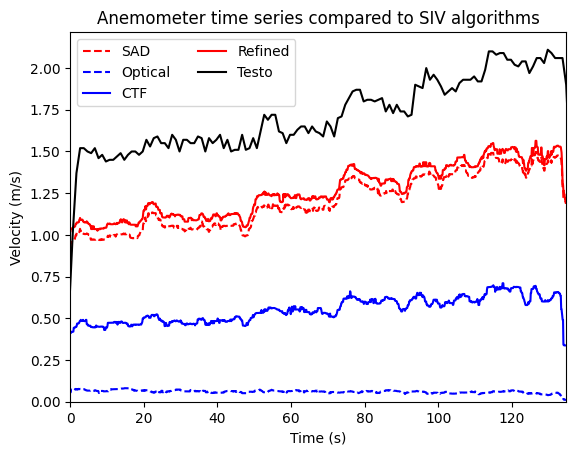

In [325]:
plt.close('all')

# plt.plot(ds[::2], pair_averages, label='measurements')
plt.plot(ds[::2], u1, label='SAD', linestyle='--', color='red')
plt.plot(ds[::2], u2, label='Optical', linestyle='--', color='blue')
plt.plot(ds[::2], u3, label='CTF', linestyle='-', color='blue')
plt.plot(ds[::2], u4, label='Refined', linestyle='-', color='red')
plt.plot(times, velocities, label='Testo', color='black')

plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')

plt.xlim(left=ds[0], right=ds[-1])
plt.ylim(bottom=0.)
plt.title('Anemometer time series compared to SIV algorithms')

plt.legend(ncol=2)
plt.savefig("../experiments/result.png", dpi=600)
plt.show()

In [322]:
std1, mean1 = torch.std_mean(-u1_avg * factor)
std2, mean2 = torch.std_mean(-u2_avg * factor)
std3, mean3 = torch.std_mean(-u3_avg * factor)
std4, mean4 = torch.std_mean(-u4_avg * factor)

t0 = torch.tensor([t for i, t in enumerate(times) if ds[0] <= times[i] <= ds[-1]])
u0 = torch.tensor([v for i, v in enumerate(velocities) if ds[0] <= times[i] <= ds[-1]])
std0, mean0 = torch.std_mean(u0)

In [283]:
# print(f'Testo  \t\t{mean0.item():.2f}\t\t{(100*std0/mean0).item():.1f}%')
# 
# print(f'SAD    \t\t{mean1.item():.2f}\t\t{(100*std1/mean1).item():.1f}%')
# print(f'Optical\t\t{mean2.item():.2f}\t\t{(100*std2/mean2).item():.1f}%')
# print(f'CTF    \t\t{mean3.item():.2f}\t\t{(100*std3/mean3).item():.1f}%')
# print(f'Refined\t\t{mean4.item():.2f}\t\t{(100*std4/mean4).item():.1f}%')

Testo  		1.72		12.4%
SAD    		1.56		33.1%
Optical		0.03		113.6%
CTF    		0.27		113.6%
Refined		1.59		31.6%


In [315]:
u1_corrected = u1[::10] * u0.mean()/u1.mean()
u2_corrected = u2[::10] * u0.mean()/u2.mean()
u3_corrected = u3[::10] * u0.mean()/u3.mean()
u4_corrected = u4[::10] * u0.mean()/u4.mean()

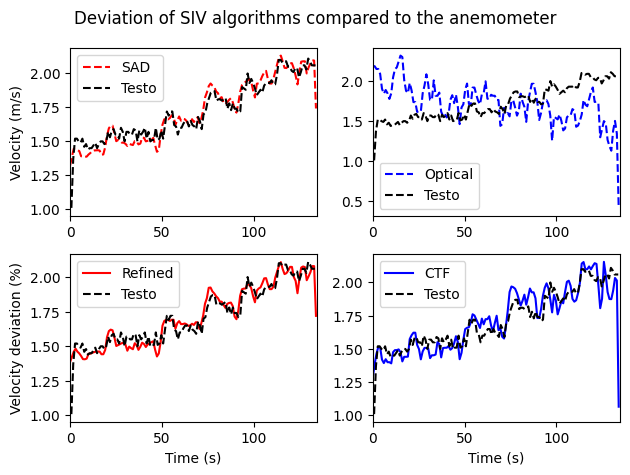

In [331]:
plt.close('all')
fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(ds[::20], u1_corrected, label='SAD', linestyle='--', color='red')
ax[0, 0].plot(t0, u0, label='Testo', color='black', linestyle='--')
ax[0, 0].set_ylabel('Velocity (m/s)')
ax[0, 0].legend()
ax[0, 0].set_xlim(left=ds[0], right=ds[-1])

ax[0, 1].plot(ds[::20], u2_corrected, label='Optical', linestyle='--', color='blue')
ax[0, 1].plot(t0, u0, label='Testo', color='black', linestyle='--')
ax[0, 1].legend()
ax[0, 1].set_xlim(left=ds[0], right=ds[-1])

ax[1, 1].plot(ds[::20], u3_corrected, label='CTF', linestyle='-', color='blue')
ax[1, 1].plot(t0, u0, label='Testo', color='black', linestyle='--')
ax[1, 1].set_xlabel('Time (s)')
ax[1, 1].legend()
ax[1, 1].set_xlim(left=ds[0], right=ds[-1])

ax[1, 0].plot(ds[::20], u4_corrected, label='Refined', linestyle='-', color='red')
ax[1, 0].plot(t0, u0, label='Testo', color='black', linestyle='--')
ax[1, 0].set_ylabel('Velocity deviation (%)')
ax[1, 0].set_xlabel('Time (s)')
ax[1, 0].legend()
ax[1, 0].set_xlim(left=ds[0], right=ds[-1])

fig.suptitle('Deviation of SIV algorithms compared to the anemometer')

fig.tight_layout()
plt.savefig("../experiments/result3.png", dpi=600)
plt.show()

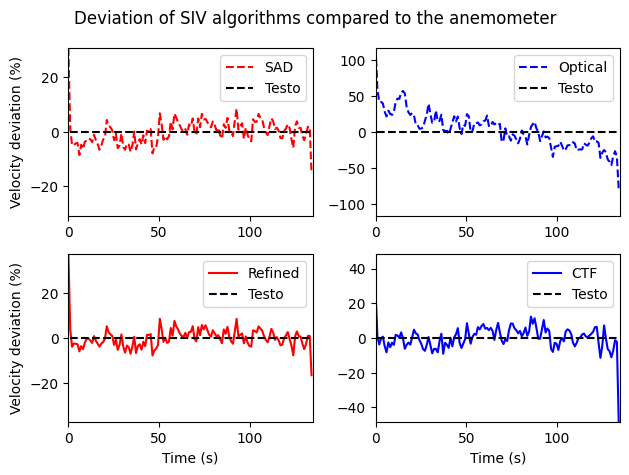

In [332]:
plt.close('all')
fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(ds[::20], 100*(u1_corrected - u0)/u0, label='SAD', linestyle='--', color='red')
ax[0, 0].plot(t0, u0 * 0, label='Testo', color='black', linestyle='--')
ax[0, 0].set_ylabel('Velocity deviation (%)')
ax[0, 0].legend()
ax[0, 0].set_xlim(left=ds[0], right=ds[-1])
ax[0, 0].set_ylim(top=(100*(u1_corrected - u0)/u0).abs().max(), bottom=-(100*(u1_corrected - u0)/u0).abs().max())

ax[0, 1].plot(ds[::20], 100*(u2_corrected - u0)/u0, label='Optical', linestyle='--', color='blue')
ax[0, 1].plot(t0, u0 * 0, label='Testo', color='black', linestyle='--')
ax[0, 1].legend()
ax[0, 1].set_xlim(left=ds[0], right=ds[-1])
ax[0, 1].set_ylim(top=(100*(u2_corrected - u0)/u0).abs().max(), bottom=-(100*(u2_corrected - u0)/u0).abs().max())

ax[1, 1].plot(ds[::20], 100*(u3_corrected - u0)/u0, label='CTF', linestyle='-', color='blue')
ax[1, 1].plot(t0, u0 * 0, label='Testo', color='black', linestyle='--')
ax[1, 1].set_xlabel('Time (s)')
ax[1, 1].legend()
ax[1, 1].set_xlim(left=ds[0], right=ds[-1])
ax[1, 1].set_ylim(top=(100*(u3_corrected - u0)/u0).abs().max(), bottom=-(100*(u3_corrected - u0)/u0).abs().max())

ax[1, 0].plot(ds[::20], 100*(u4_corrected - u0)/u0, label='Refined', linestyle='-', color='red')
ax[1, 0].plot(t0, u0 * 0, label='Testo', color='black', linestyle='--')
ax[1, 0].set_ylabel('Velocity deviation (%)')
ax[1, 0].set_xlabel('Time (s)')
ax[1, 0].legend()
ax[1, 0].set_xlim(left=ds[0], right=ds[-1])
ax[1, 0].set_ylim(top=(100*(u4_corrected - u0)/u0).abs().max(), bottom=-(100*(u4_corrected - u0)/u0).abs().max())

fig.suptitle('Deviation of SIV algorithms compared to the anemometer')

fig.tight_layout()
plt.savefig("../experiments/result2.png", dpi=600)
plt.show()

In [321]:
print(f'SAD    \t\t{(u1_corrected - u0).std().item():.3f}')
print(f'Optical\t\t{(u2_corrected - u0).std().item():.3f}')
print(f'CTF    \t\t{(u3_corrected - u0).std().item():.3f}')
print(f'Refined\t\t{(u4_corrected - u0).std().item():.3f}')

SAD    		0.072
Optical		0.418
CTF    		0.124
Refined		0.071
